In [ ]:

* https://scikit-learn.org.cn/view/17.html
* https://zhuanlan.zhihu.com/p/90479183
* https://zhuanlan.zhihu.com/p/101766505


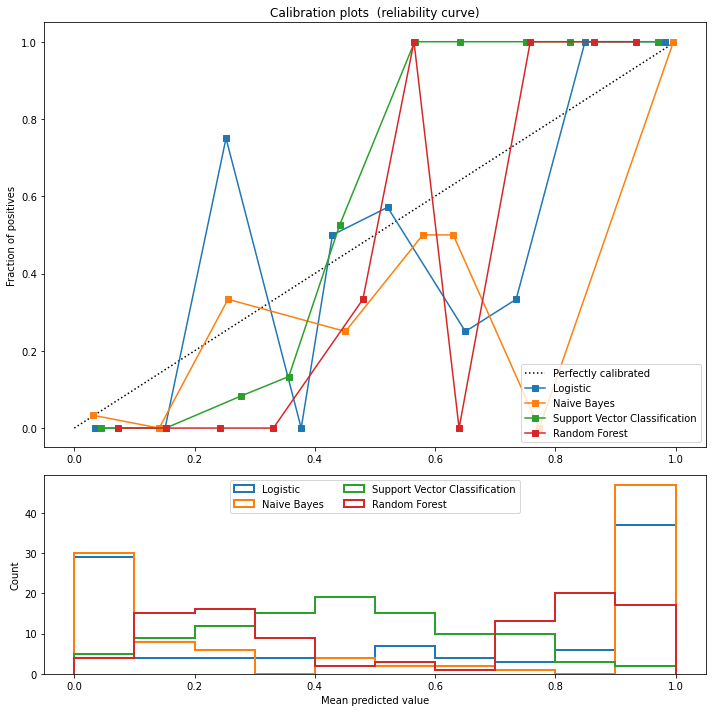

In [20]:
import numpy as np
np.random.seed(87)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=200, 
                                    n_features=20,
                                    n_informative=2, 
                                    n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


In [2]:
fraction_of_positives

array([0.01424674, 0.01894238, 0.02299819, 0.09118881, 0.20135468,
       0.33444537, 0.72693011, 0.92238988, 0.97486544, 0.99158523])

In [3]:
fraction_of_positives, mean_predicted_value

(array([0.01424674, 0.01894238, 0.02299819, 0.09118881, 0.20135468,
        0.33444537, 0.72693011, 0.92238988, 0.97486544, 0.99158523]),
 array([0.07329696, 0.15246364, 0.24539675, 0.35365315, 0.45716749,
        0.55501251, 0.66217794, 0.75962998, 0.850757  , 0.92718241]))

In [18]:
print(prob_pos.shape)
_ = prob_pos[(0.1 < prob_pos) * (prob_pos < 0.2)]
print(_.shape)

print('%:', _.shape[0] / prob_pos.shape[0])
sum(_)/len(_)


(99900,)
(16242,)
%: 0.16258258258258257


0.14808521118090243

In [12]:
max(prob_pos) - min(prob_pos)

1.0

In [16]:
(0.1 < prob_pos) * (prob_pos < 0.2)

array([False, False, False, ..., False, False,  True])

In [19]:
np.linspace(0.0, 1.0, 10 + 1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b6/sklearn/calibration.py#L873

In [29]:
bins = np.linspace(0.0, 1.0, 10 + 1)      # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
binids = np.searchsorted(bins[1:-1], prob_pos)     # 紮料分到哪個 bins
bin_sums = np.bincount(binids, weights=prob_pos, minlength=len(bins))   # 每個 bin 區間的資料合
bin_true = np.bincount(binids, weights=y_test, minlength=len(bins))     # 在那個 bin 裡面的資料 有哪些是 true
bin_total = np.bincount(binids, minlength=len(bins))
bin_total


array([ 5, 15, 15,  9,  3,  2,  1, 13, 23, 14,  0], dtype=int64)

In [ ]:


    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

In [28]:
y_test

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])